# Basic usage

In [1]:
import jax
import jax.lax
import jax.numpy as jnp
import numpy as np

In [2]:
from src.rts.config import EnvConfig
from src.rts.env import Board, EnvState, init_state, move, increase_troops
from src.rts.utils import assert_valid_state, get_legal_moves, fixed_argwhere

from src.rts.visualizaiton import visualize_board

from src.main import step

### Random play

In [ ]:
# Play a game with random moves for 1000 steps
# Visualize the board interactivly
rng_key = jax.random.PRNGKey(3)
params = EnvConfig(
    board_width = 10,
    board_height = 10,
    num_neutral_bases = 6,
    num_neutral_troops_start = 10,
    neutral_troops_min = 4,
    neutral_troops_max = 10,
    player_start_troops=5,
)
state = init_state(rng_key, params)

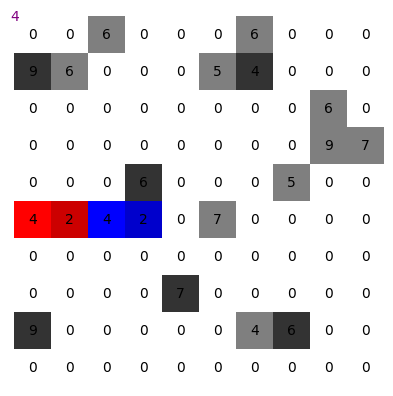

In [4]:
for i in range(1):
    rng_key, subkey = jax.random.split(rng_key)
    state = step(state, subkey)
    assert_valid_state(state)
    if i % 1 == 0:
        visualize_board(state)

# Batched

In [5]:
# Now we vmap
N = 50
rng_key = jax.random.PRNGKey(3)
rng_keys = jax.random.split(rng_key, N)

# Create the initial state for each game via vmap.
batched_init_state = jax.vmap(lambda key: init_state(key, params))
states = batched_init_state(rng_keys)

# Build a batched step function. This will take a batch of states and a batch of RNG keys.
batched_step = jax.jit(jax.vmap(step, in_axes=(0, 0)))

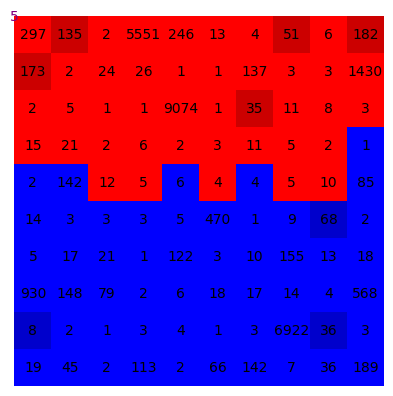

In [6]:
for i in range(5000):
    # For each parallel game, split its RNG key into two:
    # keys_split will have shape (N, 2, key_shape).
    keys_split = jax.vmap(lambda key: jax.random.split(key, 2))(rng_keys)
    # Update rng_keys to the first half and use the second half as subkeys.
    rng_keys = keys_split[:, 0]
    subkeys = keys_split[:, 1]

    # Take one step in parallel for all games.
    states = batched_step(states, subkeys)

    # Visualize and validate
    if i % 250 == 0:
        board = Board(
            player_1_troops = states.board.player_1_troops[79],
            player_2_troops = states.board.player_2_troops[79],
            neutral_troops = states.board.neutral_troops[79],
            bases = states.board.bases[79],
        )
        single_state = EnvState(board = board)
        assert_valid_state(single_state)
        visualize_board(single_state)